In [1]:
import json

In [2]:
import requests
import geopandas as gpd
import pandas as pd

In [3]:
from bs4 import BeautifulSoup
from shapely.geometry import Point
from tqdm.notebook import tqdm

## Open GIS Data

In [4]:
file_path = "data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
states_df = gpd.read_file(file_path)

## Get Distillery Data

In [5]:
headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"
}
r = requests.get(
    "https://www.distillerytrail.com/distillery-directory-map/", headers=headers
)

In [6]:
soup = BeautifulSoup(r.text, "html.parser")

In [7]:
divs = soup.find_all("div", {"class": "drts-location-entities-map-container"})
div = divs[0]
script = div.find_all("script")[0]
almost_data = script.text.split("setMarkers")[1]

In [8]:
formatted_data_in_str = "}".join(almost_data[2:].split("}")[:-2]) + "}"
formatted_data_in_str = f"[{formatted_data_in_str}]"

In [9]:
distillery_data_list = json.loads(formatted_data_in_str)

Parsing Distilleries:   0%|          | 0/2109 [00:00<?, ?it/s]

{'index': 0, 'entity_id': 17238, 'content': '<div class="drts-bs-card drts-bs-border-0 drts-bs-bg-dark drts-bs-text-white drts-map-marker-content">\n\n<div class="drts-bs-card-img-overlay drts-bs-p-2">\n<div class="drts-bs-card-title"><a href="https://www.distillerytrail.com/directory-distillery/listing/delaware-distilling-company/" class="drts-bs-text-white drts-entity-permalink drts-entity-17238" title="Delaware Distilling Company (Closed)" data-type="post" data-content-type="directory__listing" data-content-name="distillery_dir_ltg">Delaware Distilling Company (Closed)</a></div>\n<address class="drts-map-marker-address drts-bs-card-text">18693 Coastal Hwy, Rehoboth Beach, Delaware 19971, United States</address>\n</div></div>', 'lat': 38.720945, 'lng': -75.076014, 'icon': None}

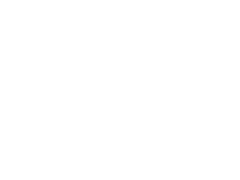

In [10]:
coord_list = []
state_counts = {}
distilleries = []
for distillery in tqdm(distillery_data_list, desc="Parsing Distilleries"):
    point = Point(distillery["lng"], distillery["lat"])
    try:
        state_code = states_df[states_df.intersects(point)]["STUSPS"].iloc[0]
        distilleries.append(point)
    except IndexError:
        print(distillery)
        continue

    if state_code not in state_counts:
        state_counts[state_code] = 1
    else:
        state_counts[state_code] += 1

In [11]:
distilleries_per_state_series = pd.Series(state_counts, name="distilleries")
distilleries_per_state_df = distilleries_per_state_series.reset_index()
distilleries_per_state_df = distilleries_per_state_df.rename(
    columns={"index": "STUSPS"}
)

## Get Winery Data

In [12]:
r = requests.get("https://winemaps.com/api/wine-maps-winery")

In [13]:
feature_collection = r.json()
for i, feature in enumerate(feature_collection["features"]):
    coords = feature["geometry"]["coordinates"]
    try:
        feature_collection["features"][i]["geometry"]["coordinates"] = [
            float(coords[0]),
            float(coords[1]),
        ]
    except ValueError:
        print(feature["properties"]["title"], feature["properties"]["address"])

Marsden Estate  56 Wiroa Road Keri Keri
Barkers Marque Wines 499 Reserve Road, RD 1, Seddon
Beach House Wines A. 93 Mere Road Hastings Hawkes Bay
I. Brajkovich 76 Guys Road, Kaikohe
Matahiwi Vineyard 286 Paierau Road RD 1, Masteron Wairarapa
Misconduct Wine Co. 375 Upper Branch Road North Penticton
Naked Range Wines 125 Rifle Range Road Smiths Gully
Hannay Wines Valley Green, 41 Viljoenshoop Road Elgin
Catherine Marshall Lavinia, 1377 Polkadraai Road (M12/Stellenbosch Arterial) Stellenbosch
South Hill Vineyards 113 Elgin Valley Road Elgin
Boekenhoutskloof Winery Excelsior Road Franschhoek
Dieu Donne Vineyards        Dieu Donne Uitkyk Street Franschhoek
La Bri La Bri Wine Estate, Excelsior Road Franschhoek
Mont Rochelle 1499 Dassenberg Road Franschhoek
Veraison Vineyard Dassenberg Road Franschhoek
Neyen Camino Apalta Km. 11 Colchagua
Quinta da Aveleira National Road, Tavora, 7 Tabuaço
Tarapacá Fundo El Rosario de Naltahua S/N 
Gisborne Wine Centre Shed 3, 50 The Esplanade Inner Harbour 

In [14]:
with open("data/wineries.geojson", "w") as f:
    f.write(json.dumps(feature_collection))

In [15]:
wineries_gdf = gpd.GeoDataFrame.from_file("data/wineries.geojson")

In [16]:
states_df[wineries_gdf["geometry"].iloc[0].intersects(states_df["geometry"])]["STUSPS"]

16    CA
Name: STUSPS, dtype: object

In [17]:
wineries_gdf = wineries_gdf[wineries_gdf["geometry"] != None]

In [18]:
def calculate_state(input_point, input_polygons):
    output_df = input_polygons[input_point.intersects(input_polygons["geometry"])][
        "STUSPS"
    ]
    if output_df.empty:
        return
    return output_df.iloc[0]

In [19]:
wineries_gdf["state_code"] = wineries_gdf["geometry"].apply(
    lambda geometry: calculate_state(geometry, states_df)
)

In [20]:
wineries_by_state_series = wineries_gdf.groupby(["state_code"]).size()

In [21]:
wineries_by_state_df = pd.DataFrame(
    {
        "STUSPS": wineries_by_state_series.index,
        "wineries": wineries_by_state_series.values,
    }
)

## Distilleries vs Wineries

In [22]:
distilleries_per_state_with_population_df = states_df.merge(
    distilleries_per_state_df, on="STUSPS", how="left"
)

In [24]:
distilleries_vs_wineries_df = distilleries_per_state_with_population_df.merge(
    wineries_by_state_df, on="STUSPS", how="left"
).fillna(0)

In [25]:
distilleries_vs_wineries_df["more_distilleries"] = distilleries_vs_wineries_df.apply(
    lambda row: row["distilleries"] > row["wineries"], axis=1
)

In [26]:
distilleries_vs_wineries_df[
    "more_distilleries_num"
] = distilleries_vs_wineries_df.apply(
    lambda row: row["distilleries"] - row["wineries"], axis=1
)

In [27]:
distilleries_vs_wineries_df.to_file("data/distilleries_vs_wineries.gpkg")